# Xarray Tips and Tricks


*This material is adapted from the [Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html), from Ryan Abernathey (Columbia University)*.

## Build a multi-file dataset from an OpenDAP server

One thing we love about xarray is the `open_mfdataset` function, which combines many netCDF files into a single xarray Dataset.

But what if the files are stored on a remote server and accessed over OpenDAP. An example can be found in NOAA's NCEP Reanalysis catalog.

https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/ncep.reanalysis/surface/catalog.html

The dataset is split into different files for each variable and year. For example, a single file for surface air temperature looks like:

[http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc](https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc.html)

We can't just call

    open_mfdataset("http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.*.nc")
    
Because wildcard expansion doesn't work with OpenDAP endpoints. The solution is to manually create a list of files to open.

In [22]:
import xarray as xr
%matplotlib inline

base_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995'

files = [f'{base_url}.{year}.nc' for year in range(2015, 2019)]
files

['http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2015.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2016.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2017.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2018.nc']

In [23]:
ds = xr.open_mfdataset(files)
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 5844)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 ... 2018-12-31T18:00:00
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(1460, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2013/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

We have now opened the entire ensemble of files on the remote server as a single xarray Dataset!

## Perform Correlation Analysis


In [24]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [25]:
import xarray as xr
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)
ds = ds.sel(time=slice('1960', '2018')).load()
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 708)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2021-03-07
    DODS_EXTRA.Unlimited_Dimension:  time

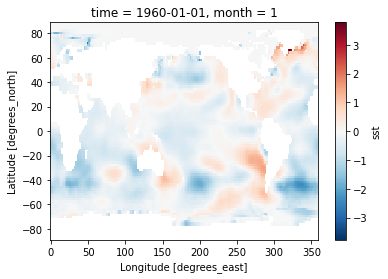

In [26]:
sst = ds.sst
sst_clim = sst.groupby('time.month').mean(dim='time')
sst_anom = sst.groupby('time.month') - sst_clim

%matplotlib inline
sst_anom[0].plot()

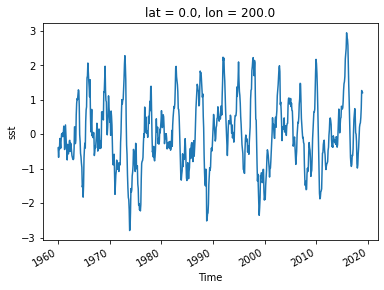

In [27]:
sst_ref = sst_anom.sel(lon=200, lat=0, method='nearest')
sst_ref.plot()

/Users/getafix/anaconda3/envs/envireef/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation btw. global SST Anomaly and SST Anomaly at one point')

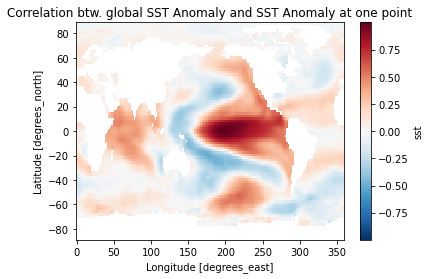

In [21]:
sst_cor = corrrelation(sst_anom, sst_ref, dims='time')
pc = sst_cor.plot()
pc.axes.set_title('Correlation btw. global SST Anomaly and SST Anomaly at one point')